In [14]:
# PYTHON 3.10 has compatability issues because collections module was changed
# use Python 3.9 or run the following:

import collections.abc
#cellrank needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

In [15]:
!pip install scvelo

In [8]:
!pip install cellrank

In [16]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import anndata as ad
import pickle

ModuleNotFoundError: No module named 'scvelo'

In [17]:
# file path names
fpath = r'/Users/jessicazhang/Dropbox (Personal)/Family Room/Qiu Research'

fdata = fpath + r'/two_samples.h5ad'
flm = fpath + r'/sc_exp4_mTBI_masked.loom'
fl = fpath + r'/sc_exp4_mTBI.loom'







## Load the Data


In [15]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False)
cr.settings.verbosity = 2

In [19]:
#adata = sc.read_h5ad(fdata)
# read data from velocyto
ldata = scv.read(fl, cache=True)
ldata_m = scv.read(flm, cache = True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


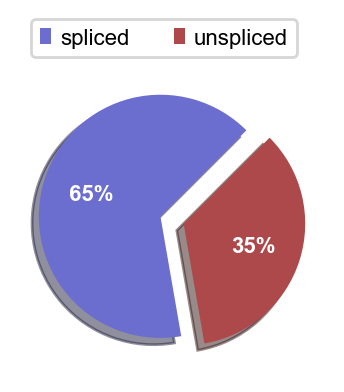

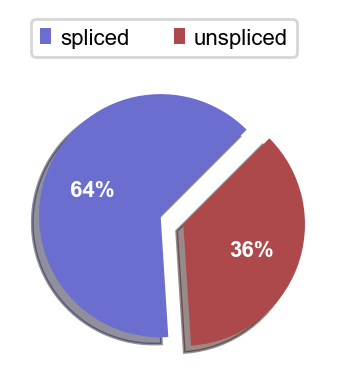

In [20]:
scv.pl.proportions(ldata)

scv.pl.proportions(ldata_m)

## Preprocessing

In [21]:
def pp(path):
    adata = sc.read_10x_mtx(path)
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
    sc.pp.log1p(adata) #change to log counts
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values
    adata.raw = adata #save raw data before processing values and further filtering
    adata = adata[:, adata.var.highly_variable] #filter highly variable
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
    sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.leiden(adata, resolution = 0.25)
    sc.tl.umap(adata)
    return adata

In [ ]:
### ONLY RUN THIS ONCE. THE SECOND LINE OF CODE saves the output to whatever directory you specify
adata = pp('/xdisk/sqiu/jessicakzhang/sc_exp4_mTBI/outs/filtered_feature_bc_matrix/')
pickle.dump(adata, open(r'/xdisk/sqiu/jessicakzhang/adata.h5ad', 'wb'))  ### change the /xdis/sqiu/jessicakzhang/ part to your desired directory


In [25]:
# this loads the previously saved output. RUN THIS and change your directory to wherever you saved your output
adata = pickle.load(open(r'/Users/jessicazhang/Dropbox (Personal)/Family Room/Qiu Research/data/adata.h5ad', 'rb'))

In [26]:
print(adata)

AnnData object with n_obs × n_vars = 25571 × 3159
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [31]:
adata = scv.utils.merge(adata, ldata)
adata_m = scv.utils.merge(adata, ldata_m)

In [28]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:56) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [32]:
scv.pp.filter_and_normalize(adata_m)
scv.pp.moments(adata_m)

computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Estimate RNA velocity

In [29]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:52) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [30]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/4 cores)


  0%|          | 0/25571 [00:00<?, ?cells/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:09:58) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [33]:
scv.tl.velocity(adata_m)
scv.tl.velocity_graph(adata_m)

computing velocities
    finished (0:00:53) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/4 cores)


  0%|          | 0/25571 [00:00<?, ?cells/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:13:32) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [34]:
scv.set_figure_params()

In [36]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGCACTCGC     1022               1022        1524.0              0.0   
AAACCCAAGCCTCATA      967                967        1477.0              0.0   
AAACCCAAGCTTACGT     1468               1468        2423.0              0.0   
AAACCCAAGGCTAACG     1540               1539        2885.0              0.0   
AAACCCAAGTCAGCGA     2193               2192        4439.0              0.0   
...                   ...                ...           ...              ...   
TTTGTTGTCGAATCCA     2865               2864        6208.0              0.0   
TTTGTTGTCGATCCCT     1459               1459        2329.0              0.0   
TTTGTTGTCTATACGG     3234               3233        7474.0              0.0   
TTTGTTGTCTGAATGC      913                913        1312.0              0.0   
TTTGTTGTCTGTGTGA      709                709        1103.0              0.0   

                  pct_counts_mt leiden  initial_size_spliced  \
AAACCCAAGCACTCGC            0.0      5                   999   
AAACCCAAGCCTCATA            0.0     10                   705   
AAACCCAAGCTTACGT            0.0      0                  1331   
AAACCCAAGGCTAACG            0.0      8                   688   
AAACCCAAGTCAGCGA            0.0      7                  1228   
...                         ...    ...                   ...   
TTTGTTGTCGAATCCA            0.0     10                  1959   
TTTGTTGTCGATCCCT            0.0      5                   912   
TTTGTTGTCTATACGG            0.0      1                  3378   
TTTGTTGTCTGAATGC            0.0      6                   637   
TTTGTTGTCTGTGTGA            0.0      3                   645   

                  initial_size_unspliced  initial_size    n_counts  \
AAACCCAAGCACTCGC                     205         999.0  450.321167   
AAACCCAAGCCTCATA                     479         705.0  189.917068   
AAACCCAAGCTTACGT                     576        1331.0 -239.231995   
AAACCCAAGGCTAACG                    1664         688.0  -39.880863   
AAACCCAAGTCAGCGA                    2386        1228.0 -246.651855   
...                                  ...           ...         ...   
TTTGTTGTCGAATCCA                    3181        1959.0  149.841156   
TTTGTTGTCGATCCCT                    1004         912.0  383.893799   
TTTGTTGTCTATACGG                    2710        3378.0 -215.620255   
TTTGTTGTCTGAATGC                     416         637.0  919.957703   
TTTGTTGTCTGTGTGA                     178         645.0   78.155701   

                  velocity_self_transition  
AAACCCAAGCACTCGC                  0.194536  
AAACCCAAGCCTCATA                  0.085311  
AAACCCAAGCTTACGT                  0.068246  
AAACCCAAGGCTAACG                  0.172723  
AAACCCAAGTCAGCGA                  0.188395  
...                                    ...  
TTTGTTGTCGAATCCA                  0.148360  
TTTGTTGTCGATCCCT                  0.183483  
TTTGTTGTCTATACGG                  0.168162  
TTTGTTGTCTGAATGC                  0.229043  
TTTGTTGTCTGTGTGA                  0.140169  

[25571 rows x 11 columns]

In [50]:
adata.var

gene_ids    feature_types  n_cells     mt  \
Sox17          ENSMUSG00000025902  Gene Expression      173  False   
Rgs20          ENSMUSG00000002459  Gene Expression     2922  False   
St18           ENSMUSG00000033740  Gene Expression     3803  False   
Prex2          ENSMUSG00000048960  Gene Expression     3808  False   
Eya1           ENSMUSG00000025932  Gene Expression     1047  False   
...                           ...              ...      ...    ...   
Arhgap6        ENSMUSG00000031355  Gene Expression      511  False   
Gm15261        ENSMUSG00000087201  Gene Expression      178  False   
G530011O06Rik  ENSMUSG00000072844  Gene Expression      145  False   
Gm15726        ENSMUSG00000087263  Gene Expression      198  False   
mt-Nd6         ENSMUSG00000064368  Gene Expression     2429  False   

               n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
Sox17                        173     0.006983              99.350527   
Rgs20                       2922     0.153734              89.030296   
St18                        3803     0.355258              85.722867   
Prex2                       3808     0.220220              85.704096   
Eya1                        1047     0.044337              96.069377   
...                          ...          ...                    ...   
Arhgap6                      511     0.022412              98.081616   
Gm15261                      178     0.007358              99.331757   
G530011O06Rik                145     0.005781              99.455644   
Gm15726                      198     0.007734              99.256673   
mt-Nd6                      2429     0.101025              90.881105   

               total_counts  highly_variable     means  ...       std  \
Sox17                 186.0             True  0.041410  ...  0.157562   
Rgs20                4095.0             True  0.555735  ...  0.616770   
St18                 9463.0             True  0.855416  ...  0.774224   
Prex2                5866.0             True  0.811116  ...  0.767419   
Eya1                 1181.0             True  0.204435  ...  0.362255   
...                     ...              ...       ...  ...       ...   
Arhgap6               597.0             True  0.113134  ...  0.261098   
Gm15261               196.0             True  0.044370  ...  0.161044   
G530011O06Rik         154.0             True  0.032631  ...  0.140437   
Gm15726               206.0             True  0.042153  ...  0.160586   
mt-Nd6               2691.0             True  0.465273  ...  0.557926   

                        Accession  Chromosome        End      Start Strand  \
Sox17          ENSMUSG00000025902           1    4497354    4490931      -   
Rgs20          ENSMUSG00000002459           1    5070285    4909576      -   
St18           ENSMUSG00000033740           1    6860940    6487231      +   
Prex2          ENSMUSG00000048960           1   11303681   10993465      +   
Eya1           ENSMUSG00000025932           1   14310235   14168954      -   
...                           ...         ...        ...        ...    ...   
Arhgap6        ENSMUSG00000031355           X  169304435  168795099      +   
Gm15261        ENSMUSG00000087201           X  169106536  169037674      -   
G530011O06Rik  ENSMUSG00000072844           X  169978917  169975043      -   
Gm15726        ENSMUSG00000087263           X  169985232  169979047      -   
mt-Nd6         ENSMUSG00000064368           M      14070      13552      -   

               velocity_gamma  velocity_qreg_ratio velocity_r2  velocity_genes  
Sox17                0.758868             0.843188    0.298217            True  
Rgs20                2.313587             7.342623    0.041251            True  
St18                 6.353457            18.881983    0.078382            True  
Prex2                2.277579             3.793348    0.383436            True  
Eya1                 1.038524             2.950008    0.025199            True  
...                

In [37]:
adata_m.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGCACTCGC     1022               1022        1524.0              0.0   
AAACCCAAGCCTCATA      967                967        1477.0              0.0   
AAACCCAAGCTTACGT     1468               1468        2423.0              0.0   
AAACCCAAGGCTAACG     1540               1539        2885.0              0.0   
AAACCCAAGTCAGCGA     2193               2192        4439.0              0.0   
...                   ...                ...           ...              ...   
TTTGTTGTCGAATCCA     2865               2864        6208.0              0.0   
TTTGTTGTCGATCCCT     1459               1459        2329.0              0.0   
TTTGTTGTCTATACGG     3234               3233        7474.0              0.0   
TTTGTTGTCTGAATGC      913                913        1312.0              0.0   
TTTGTTGTCTGTGTGA      709                709        1103.0              0.0   

                  pct_counts_mt leiden  initial_size_spliced  \
AAACCCAAGCACTCGC            0.0      5                   999   
AAACCCAAGCCTCATA            0.0     10                   705   
AAACCCAAGCTTACGT            0.0      0                  1331   
AAACCCAAGGCTAACG            0.0      8                   688   
AAACCCAAGTCAGCGA            0.0      7                  1228   
...                         ...    ...                   ...   
TTTGTTGTCGAATCCA            0.0     10                  1959   
TTTGTTGTCGATCCCT            0.0      5                   912   
TTTGTTGTCTATACGG            0.0      1                  3378   
TTTGTTGTCTGAATGC            0.0      6                   637   
TTTGTTGTCTGTGTGA            0.0      3                   645   

                  initial_size_unspliced  initial_size    n_counts  \
AAACCCAAGCACTCGC                     205         999.0  450.321167   
AAACCCAAGCCTCATA                     479         705.0  189.917068   
AAACCCAAGCTTACGT                     576        1331.0 -239.231995   
AAACCCAAGGCTAACG                    1664         688.0  -39.880863   
AAACCCAAGTCAGCGA                    2386        1228.0 -246.651855   
...                                  ...           ...         ...   
TTTGTTGTCGAATCCA                    3181        1959.0  149.841156   
TTTGTTGTCGATCCCT                    1004         912.0  383.893799   
TTTGTTGTCTATACGG                    2710        3378.0 -215.620255   
TTTGTTGTCTGAATGC                     416         637.0  919.957703   
TTTGTTGTCTGTGTGA                     178         645.0   78.155701   

                  velocity_self_transition  
AAACCCAAGCACTCGC                  0.194536  
AAACCCAAGCCTCATA                  0.085311  
AAACCCAAGCTTACGT                  0.068246  
AAACCCAAGGCTAACG                  0.172723  
AAACCCAAGTCAGCGA                  0.188395  
...                                    ...  
TTTGTTGTCGAATCCA                  0.148360  
TTTGTTGTCGATCCCT                  0.183483  
TTTGTTGTCTATACGG                  0.168162  
TTTGTTGTCTGAATGC                  0.229043  
TTTGTTGTCTGTGTGA                  0.140169  

[25571 rows x 11 columns]

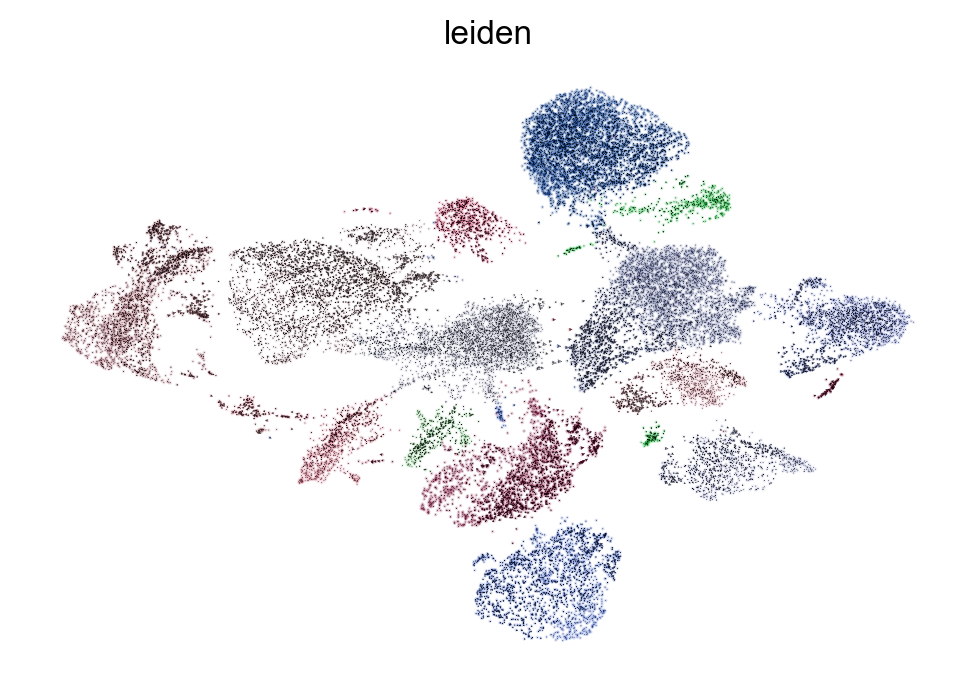

computing velocity embedding
    finished (0:00:15) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


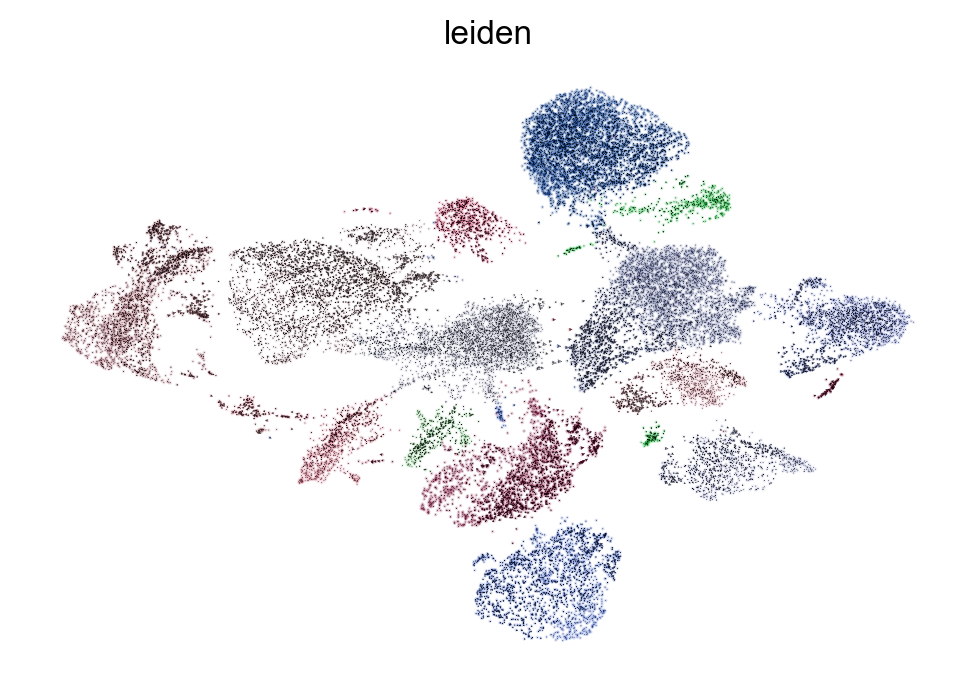

In [43]:
scv.pl.velocity_embedding(adata, basis = 'umap', color = 'leiden')
scv.pl.velocity_embedding(adata_m, basis = 'umap', color = 'leiden')

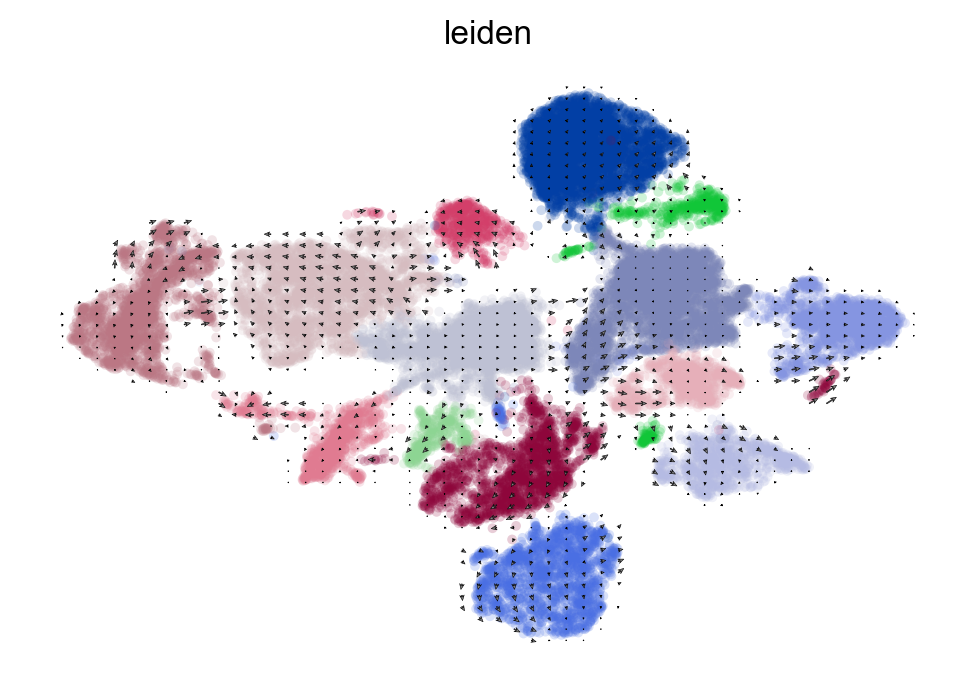

In [46]:
scv.pl.velocity_embedding_grid(adata, basis = 'umap', color = 'leiden')
#scv.pl.velocity_embedding_grid(adata_m, basis = 'umap', color = 'leiden')

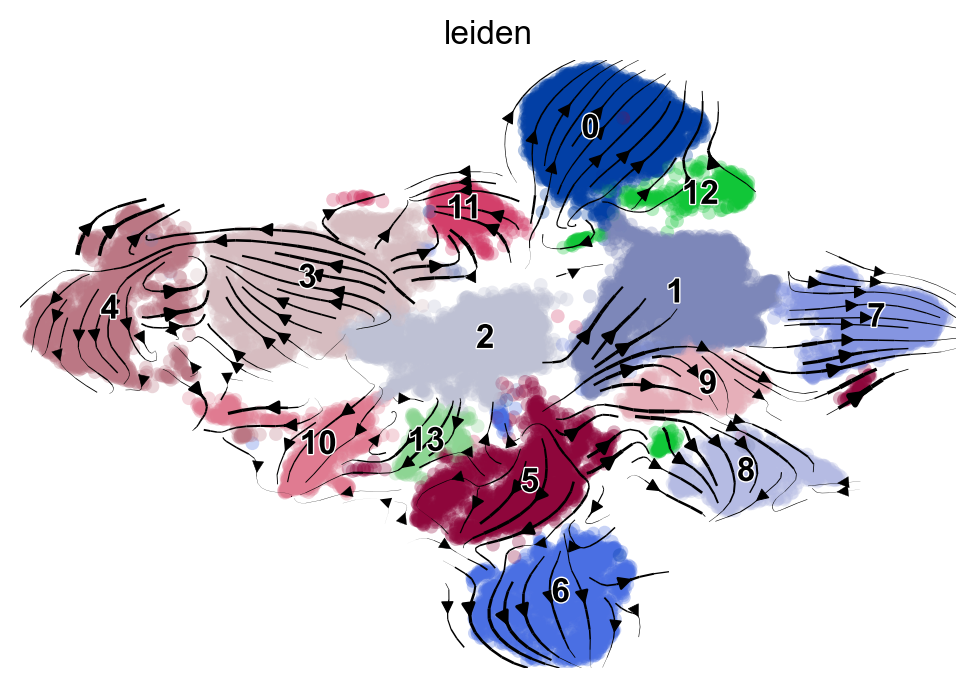

In [47]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = 'leiden')
#scv.pl.velocity_embedding_stream(adata_m, basis = 'umap', color = 'leiden')



In [52]:
scv.tl.rank_velocity_genes(adata, groupby = 'leiden', min_corr=0.3)

ranking velocity genes
    finished (0:00:57) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [53]:
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

0        1       2      3        4       5        6         7  \
0    Slit3  Phactr1   Gnai2    Ntm   Dock10   Ptprm      Cd9   Galntl6   
1  Galnt17    Kcnq5    Sgcz  Farp1   Zfp536   S1pr1   Tgfbr2      Ryr3   
2   Slc4a4    Ptprd  Tmem47   Msi2     Ano4   Ptprg  Rasgrp3  Cntnap5c   
3     Cdh9    Car10   Ptprd  Ptprt  Gm16168   Pdgfd    Runx1    Cacnb2   
4   Ahcyl2    Unc5d     Mt3   Gli3   Phlpp1  Tbc1d4    Tmcc3   Cntnap2   

         8       9        10      11        12        13  
0    Kcnc2  Garnl3   Slc35f1   Grik4  Cntnap5a   Arhgap6  
1  Galntl6    Etl4     Ptprt  Shisa6    Sema5a      Utrn  
2  Cntnap2    Grm8    Brinp3   Kcnq5     Mctp1      Dlc1  
3    Grik1  Mgat4c  Tmem132d   Tafa1    Pcdh15     Rbms1  
4      Alk  Hs3st2    Adam12  Mgat4c     Kcnh7  Slc38a11

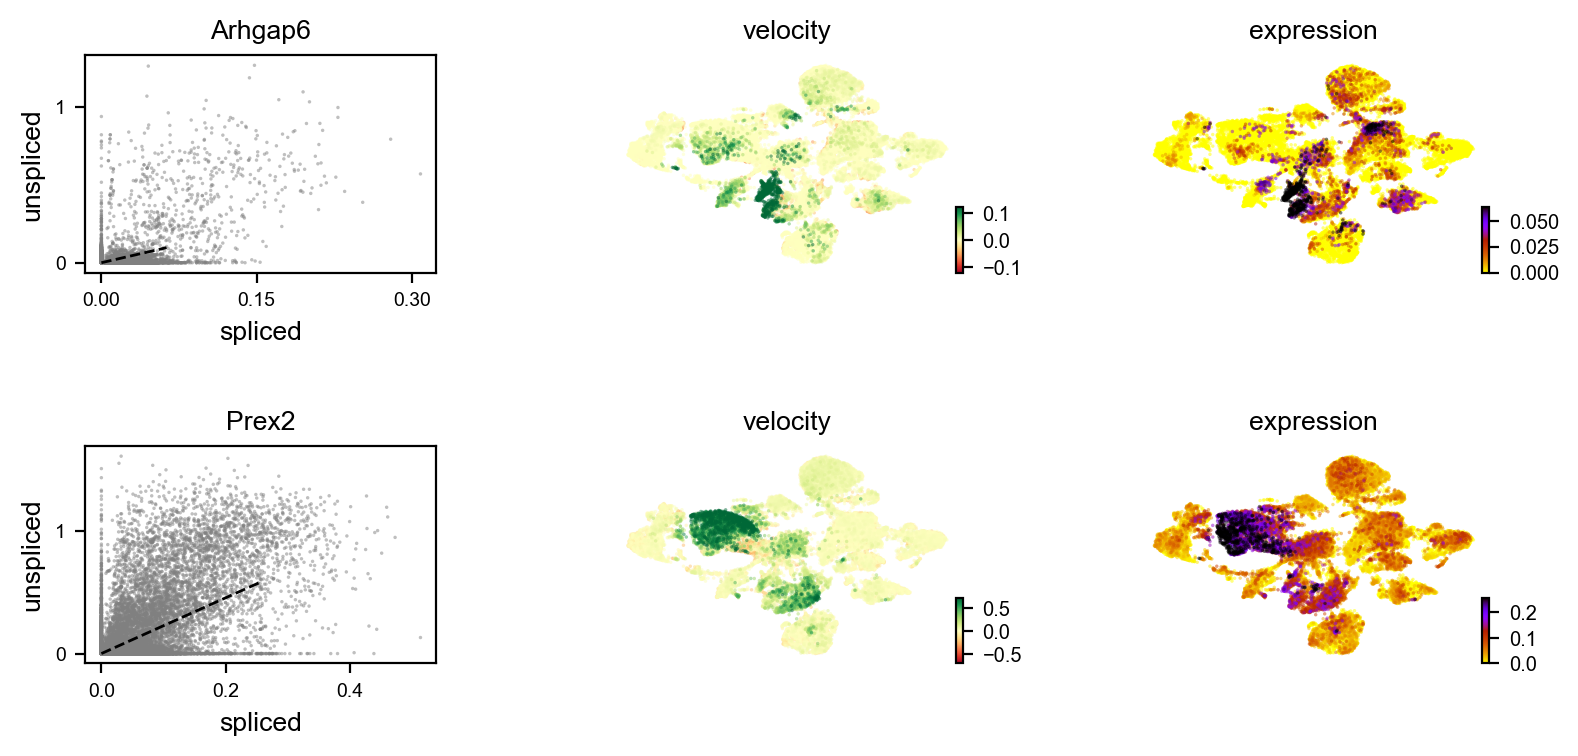

In [51]:
#### CHANGE THE GENES TO SEE DIFFERENT RNA VELOCITY ANALYSES Look at output 53 (cell above) to find some interesting genes
scv.pl.velocity(adata, ['Arhgap6', 'Prex2'])

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


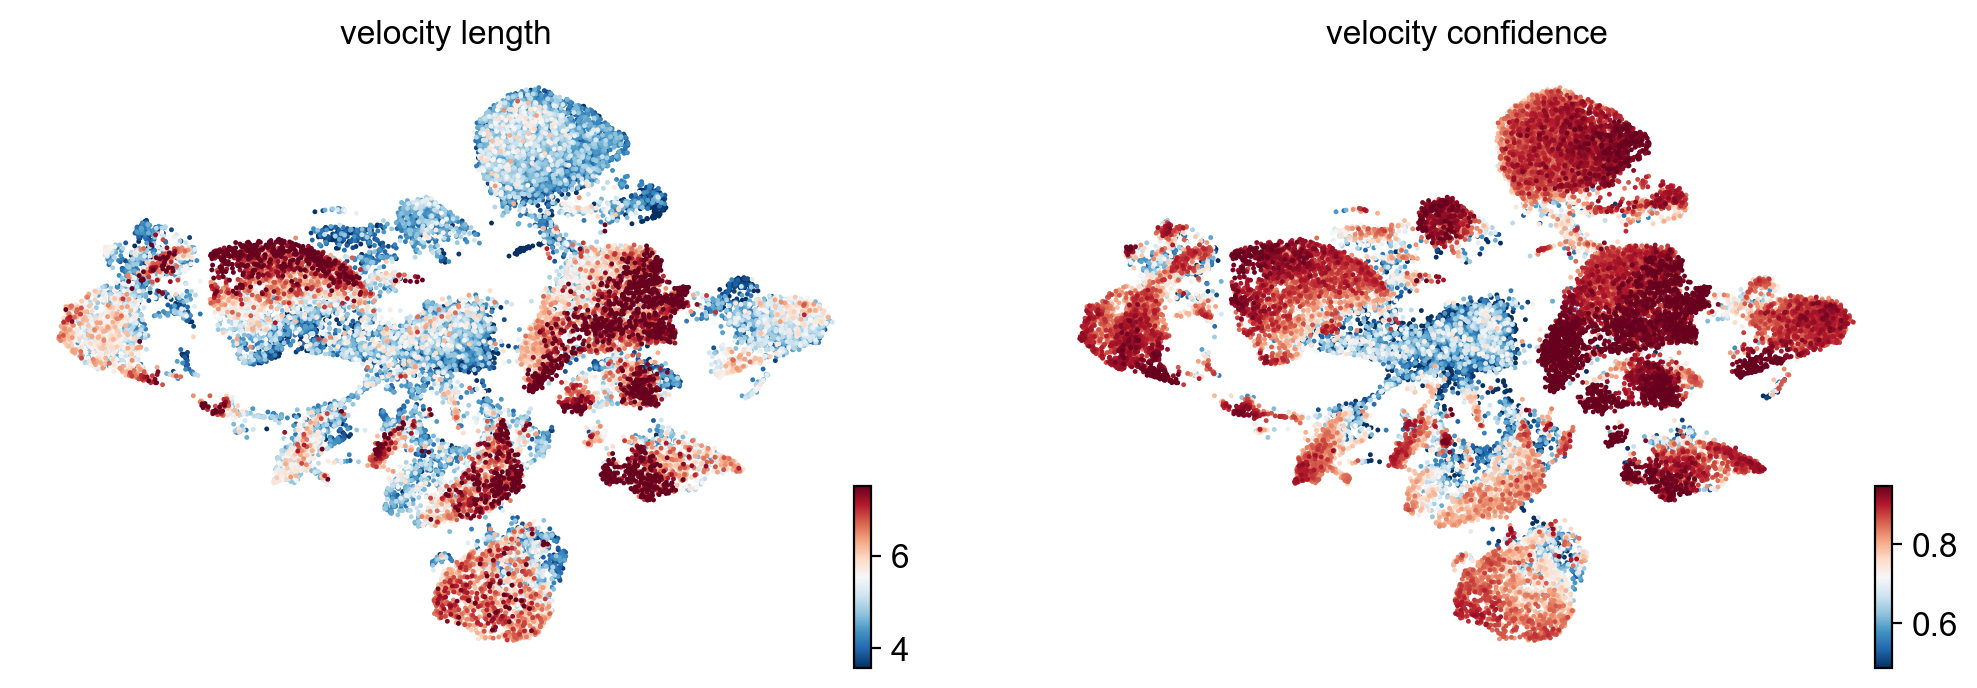

In [54]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c = keys, perc = [5,95])

In [55]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGCACTCGC     1022               1022        1524.0              0.0   
AAACCCAAGCCTCATA      967                967        1477.0              0.0   
AAACCCAAGCTTACGT     1468               1468        2423.0              0.0   
AAACCCAAGGCTAACG     1540               1539        2885.0              0.0   
AAACCCAAGTCAGCGA     2193               2192        4439.0              0.0   
...                   ...                ...           ...              ...   
TTTGTTGTCGAATCCA     2865               2864        6208.0              0.0   
TTTGTTGTCGATCCCT     1459               1459        2329.0              0.0   
TTTGTTGTCTATACGG     3234               3233        7474.0              0.0   
TTTGTTGTCTGAATGC      913                913        1312.0              0.0   
TTTGTTGTCTGTGTGA      709                709        1103.0              0.0   

                  pct_counts_mt leiden  initial_size_spliced  \
AAACCCAAGCACTCGC            0.0      5                   999   
AAACCCAAGCCTCATA            0.0     10                   705   
AAACCCAAGCTTACGT            0.0      0                  1331   
AAACCCAAGGCTAACG            0.0      8                   688   
AAACCCAAGTCAGCGA            0.0      7                  1228   
...                         ...    ...                   ...   
TTTGTTGTCGAATCCA            0.0     10                  1959   
TTTGTTGTCGATCCCT            0.0      5                   912   
TTTGTTGTCTATACGG            0.0      1                  3378   
TTTGTTGTCTGAATGC            0.0      6                   637   
TTTGTTGTCTGTGTGA            0.0      3                   645   

                  initial_size_unspliced  initial_size    n_counts  \
AAACCCAAGCACTCGC                     205         999.0  450.321167   
AAACCCAAGCCTCATA                     479         705.0  189.917068   
AAACCCAAGCTTACGT                     576        1331.0 -239.231995   
AAACCCAAGGCTAACG                    1664         688.0  -39.880863   
AAACCCAAGTCAGCGA                    2386        1228.0 -246.651855   
...                                  ...           ...         ...   
TTTGTTGTCGAATCCA                    3181        1959.0  149.841156   
TTTGTTGTCGATCCCT                    1004         912.0  383.893799   
TTTGTTGTCTATACGG                    2710        3378.0 -215.620255   
TTTGTTGTCTGAATGC                     416         637.0  919.957703   
TTTGTTGTCTGTGTGA                     178         645.0   78.155701   

                  velocity_self_transition  velocity_length  \
AAACCCAAGCACTCGC                  0.194536             5.23   
AAACCCAAGCCTCATA                  0.085311             5.27   
AAACCCAAGCTTACGT                  0.068246             3.95   
AAACCCAAGGCTAACG                  0.172723             6.33   
AAACCCAAGTCAGCGA                  0.188395             4.30   
...                                    ...              ...   
TTTGTTGTCGAATCCA                  0.148360             4.96   
TTTGTTGTCGATCCCT                  0.183483             5.26   
TTTGTTGTCTATACGG                  0.168162             6.54   
TTTGTTGTCTGAATGC                  0.229043             6.39   
TTTGTTGTCTGTGTGA                  0.140169             7.01   

                  velocity_confidence  velocity_confidence_transition  
AAACCCAAGCACTCGC             0.738872                        0.042070  
AAACCCAAGCCTCATA             0.794536                        0.217606  
AAACCCAAGCTTACGT             0.928340                        0.185647  
AAACCCAAGGCTAACG             0.874283                        0.051619  
AAACCCAAGTCAGCGA             0.869426                        0.059157  
...                               ...                             ...  
TTTGTTGTCGAATCCA             0.751981                        0.160295  
TTTGTTGTCGATCCCT             0.593251                        0.190529  
TTTGTTGTCTATACGG             0.924557                 

computing terminal states
    identified 3 regions of root cells and 4 regions of end points .
    finished (0:00:11) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


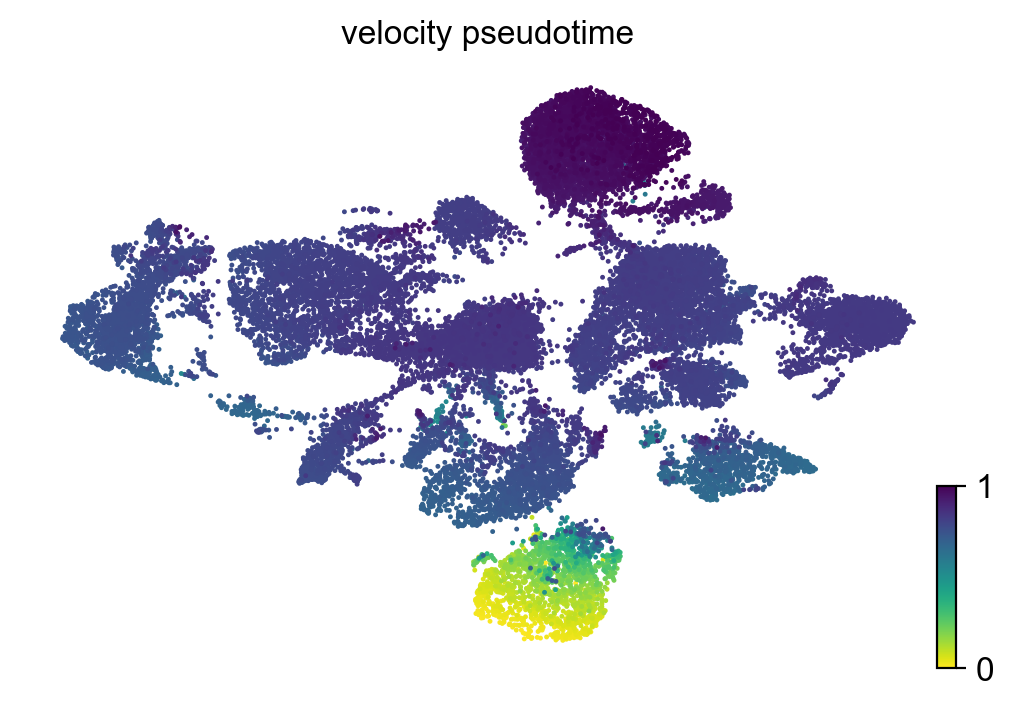

In [56]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color = 'velocity_pseudotime')

recovering dynamics (using 4/4 cores)


  0%|          | 0/1441 [00:00<?, ?gene/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (1:02:18) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:03:14) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/4 cores)


  0%|          | 0/25571 [00:00<?, ?cells/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:02:47) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:17) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


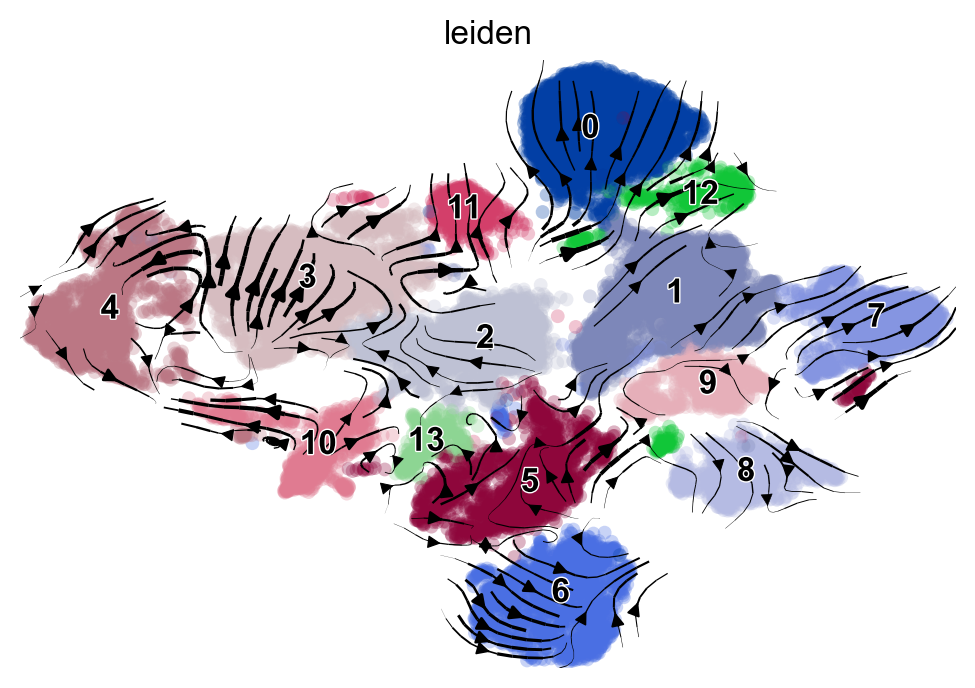

In [57]:
## THIS IS VERY TIME AND COMPUTATIONALLY CONSUMING
## WILL TAKE OVER AN HOUR TO RUN
scv.tl.recover_dynamics(adata, n_jobs = 20)
scv.tl.velocity(adata, mode = 'dynamical')
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = 'leiden')

computing latent time using root_cells as prior
    finished (0:00:59) --> added 
    'latent_time', shared time (adata.obs)


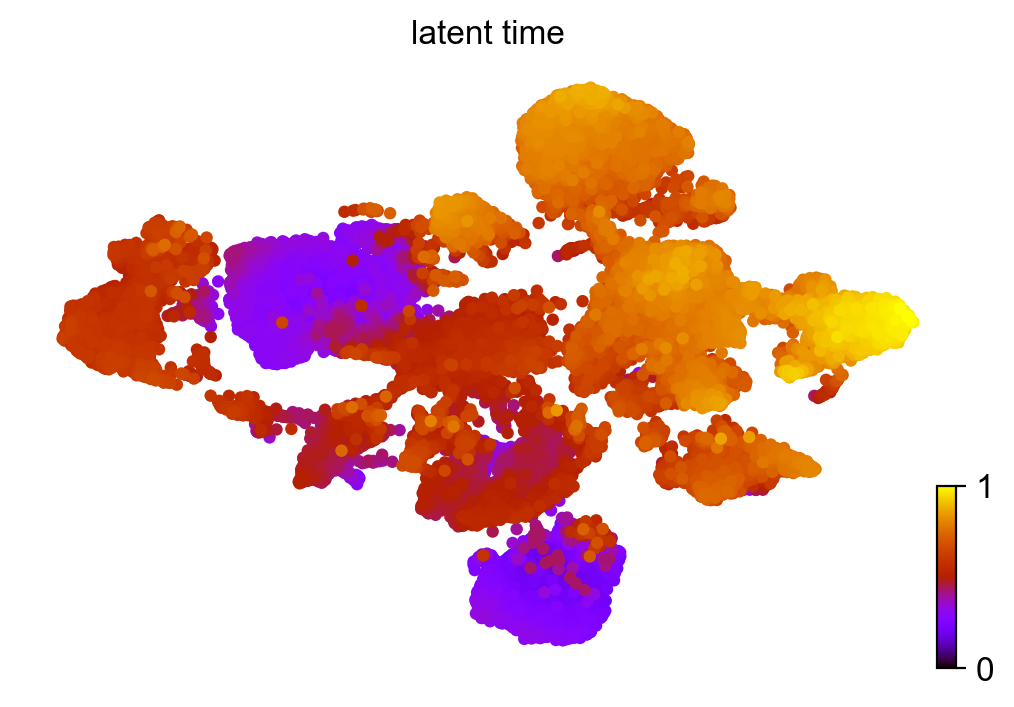

In [58]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color = 'latent_time', color_map = 'gnuplot', size = 80)